# User to Item Recommendation system

Loading Datasets. 

In [3]:
import pandas as pd
import numpy as np
from keras.models import load_model

links = pd.read_csv('gdrive/My Drive/links.csv')
movies = pd.read_csv('gdrive/My Drive/movies.csv')
ratings = pd.read_csv('gdrive/My Drive/ratings.csv')
tags = pd.read_csv('gdrive/My Drive/tags.csv')

Using TensorFlow backend.


Cleaning genres string. Replacing "|" with " " and replacing null with blank string.

In [0]:
tags_1 = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
df = pd.merge(movies, tags_1,on='movieId', how='left')
df['genres'] = df['genres'].str.replace('|',' ')
df.fillna("",inplace=True)

Label Encoding "movieId" column so that the movieId's start with 1 and end with 9742 (max number of movies in the dataset).



In [0]:
from sklearn.preprocessing import LabelEncoder
item_enc = LabelEncoder()

df['movieId'] = item_enc.fit_transform(df['movieId'].values)

df['movieId'] = df['movieId']+1

Converting upper case characters to lower case. To avoid duplicates when the words are tokenized.

In [ ]:
import string
df.genres = df.genres.apply(lambda x: x.lower())
df.genres = df.genres.apply(lambda x: x.translate(string.punctuation))


In [0]:
ratings['movieId'] = item_enc.fit_transform(ratings['movieId'].values)

ratings['movieId'] = ratings['movieId']+1


We will be grouping both movies and their timestamps by userID. Since movies are arranged in ascending order, we will have to reorder movies PER user according to their timestamp, which will result in a better sequence order. 

In [0]:
user_movies_watched = pd.DataFrame(ratings.groupby(['userId']).apply(lambda x: [list(x['movieId'])]).apply(pd.Series))
all_timestamps = pd.DataFrame(ratings.groupby(['userId']).apply(lambda x: [list(x['timestamp'])]).apply(pd.Series))
user_movies_watched = pd.concat([user_movies_watched,all_timestamps], axis=1)

user_movies_watched.columns = ['movies','timestamps']

Grouping movies by Genres.

In [0]:
genre_classes = pd.DataFrame(df.groupby(['genres']).apply(lambda x: [list(x['movieId'])]).apply(pd.Series)).reset_index()
genre_classes.columns = ['genres','movieId']

Adding a new column which will now represent the unique genre strings.



In [12]:
genre_classes_column = [int(i) for i in range(1,952)]
genre_classes['genres_class'] = np.array(genre_classes_column)
genre_classes

,genres,movieId,genres_class
0,(no genres listed),"[8518, 8685, 8688, 8783, 8837, 8903, 9034, 905...",1
1,action,"[9, 64, 173, 216, 556, 877, 1144, 1202, 1648, ...",2
2,action adventure,"[575, 607, 637, 802, 901, 991, 1209, 1368, 161...",3
3,action adventure animation,"[6926, 7923, 7924, 7925, 7926, 7942, 7943, 795...",4
4,action adventure animation children,"[7902, 7903, 7905, 7907, 8345, 9709]",5
...,...,...,...
946,sci-fi thriller,"[669, 1321, 2599, 2935, 3618, 3671, 3943, 5361...",947
947,sci-fi thriller imax,[7688],948
948,thriller,"[113, 162, 207, 332, 367, 399, 428, 474, 553, ...",949
949,war,"[2006, 2007, 4388, 6787]",950


Adding a new column to the main dataframe, which will now hold the tokenized genres.



In [0]:
genre_classes_column = [int(i) for i in range(1,952)]
genre_classes['genres_class'] = np.array(genre_classes_column)

genre_dict = pd.Series(genre_classes.genres_class.values,index=genre_classes.genres).to_dict()
df_gen = df.genres.values
df_gen=[genre_dict[i] for i in df_gen]
df['genres_class'] = np.array(df_gen)

A dictionary of movies and its unique genre_class. 

In [0]:
genre_movie_dict = pd.Series(df.genres_class.values,index=df.movieId).to_dict()

In [16]:
df.head(3)

,movieId,title,genres,tag,genres_class
0,1,Toy Story (1995),adventure animation children comedy fantasy,pixar pixar fun,352
1,2,Jumanji (1995),adventure children fantasy,fantasy magic board game robin williams game,418
2,3,Grumpier Old Men (1995),comedy romance,moldy old,733


Obtaining a single long list which has all the movies seen by every user. Also obtaining a single long list which has all the associated timestamps.

In [0]:
movies_all = user_movies_watched.movies.values
time_stamps_all = user_movies_watched.timestamps.values

For every user(indicated by the sublist **i**, we will be sorting/rearranging movies according to their timestamps.

In [ ]:
movies_list = []
for i in range(0,len(movies_all)):
    movies_list.append([x for _,x in sorted(zip(time_stamps_all[i],movies_all[i]))])

Flattening the list of lists into one long list. Later we will create a sequence of 18 or 36.

In [0]:
movies_all = [item for sublist in movies_list for item in sublist]
genres_all = [genre_movie_dict[item] for item in movies_all]

Will be creating a sequence of 18 movies (which will be our movie Input). Next_movie list will have the movie which immediately follows after a particular sequence.

In [0]:
maxlen = 18
step = 18
movies_list = []
genres_list = []
next_movie = []

for i in range(0, len(movies_all) - maxlen, step):
    movies_list.append(movies_all[i: i + maxlen])
    next_movie.append(movies_all[i + maxlen])
    genres_list.append(genres_all[i: i + maxlen])
    

In [22]:
gen_size = max(genres_all)
movies_size = max(movies_all)

print(gen_size,movies_size)

951 9724


Scaling movies array.

In [0]:
x_mov = np.asarray(movies_list).astype('float32')/9724
x_gen = np.asarray(genres_list)

One hot encoded outputs.


In [0]:
y = np.zeros((len(movies_list), 9743), dtype=np.bool)
for i in range (0,len(movies_list)):
    for j in range (0,maxlen):
        y[i, next_movie[j]] = 1

In [28]:
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Custom accuracy metric to assess multi label performance.

In [0]:
from keras import backend as K

def full_multi_label_metric(y_true, y_pred):
    comp = K.equal(y_true, K.round(y_pred))
    return K.cast(K.all(comp, axis=-1), K.floatx())

The model.

In [0]:
import keras
from keras.layers import Concatenate, Dense, Dropout, Flatten, LSTM
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda
from keras.layers import Bidirectional

def rec():

    genres = Input(shape=(18,))
    g = Embedding(gen_size+1, 50)(genres)
    g = Flatten()(g)

    movies = Input(shape=(18,))
    
    x = Concatenate()([movies, g])
    x = Reshape((1,918))(x)
    x = LSTM(100) (x)
    x = Dense(9743)(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=[movies, genres], outputs=x)
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    return model


In [ ]:
model = rec()
model.summary()

In [ ]:
history = model.fit(x=[x_mov,x_gen], y=y, batch_size=16, epochs=100, verbose=2)

loss and accuracy plots.

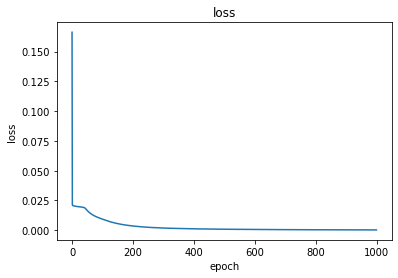

In [90]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Given a trained model and a seed movie sequence, we generate new movie recommendation by repeatedly:

    1) Drawing from the model a probability distribution over the next movie given the sequence available so far
    2) Reweighting the distribution to a certain "temperature"
    3) Sampling the next movie at random according to the reweighted distribution
    4) Adding the new movie at the end of the available movie sequence


In [0]:
def sample(preds, temperature=0.1):
    preds = np.asarray(preds).astype('float64')
    exp_preds = preds - np.exp(temperature)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    argmax = np.argmax(probas)
    return [argmax,genre_movie_dict[argmax]]

predict

In [0]:
import random

start_index = random.randint(0, len(movies_all) - maxlen - 1)
generated_seed = movies_all[start_index: start_index + maxlen]

generated_seed = [1]
genre_seed = [genre_movie_dict[i] for i in generated_seed]
N = 18 - len(generated_seed)
generated_seed = np.pad(generated_seed, (0, N), 'constant')
generated_seed = generated_seed.tolist()
genre_seed = np.pad(genre_seed, (0, N), 'constant')
genre_seed = genre_seed.tolist()
a = generated_seed
print('--- Generating with seed ---')
print(generated_seed)
print('--- --- --- --- --- ---')
next_word = []

for i in range(40): #generate 20 words

    array_seed = np.asarray(generated_seed).astype('float32')/9724
    preds = model.predict([np.array([array_seed,]),np.array([genre_seed,])])[0]
    next_index = sample(preds)
    next_word.append(next_index[0])
    generated_seed.append(next_index[0])
    genre_seed.append(next_index[1])       
    generated_seed = generated_seed[1:]
    genre_seed = genre_seed[1:]

Results.

In [187]:
df.set_index("movieId").loc[next_word].reset_index()

,movieId,Title,Genres,Tags,genres_class
0,258,Pulp Fiction (1994),comedy crime drama thriller,good dialogue great soundtrack non-linear cult...,649
1,99,Taxi Driver (1976),crime drama thriller,assassination,774
2,419,Jurassic Park (1993),action adventure sci-fi thriller,dinosaur,130
3,2084,"Yards, The (2000)",crime drama,,748
4,250,Natural Born Killers (1994),action crime thriller,brutality controversial dark comedy psychedeli...,261
5,303,Ace Ventura: Pet Detective (1994),comedy,,635
6,278,"Shawshank Redemption, The (1994)",crime drama,prison stephen king wrongful imprisonment morg...,748
7,521,Fargo (1996),comedy crime drama thriller,based on a true story dark comedy kidnapping s...,649
8,312,"Crow, The (1994)",action crime fantasy thriller,,245
9,487,True Romance (1993),crime thriller,,796
